ECE 5460, Au25

Solution for PyTorch Tutorial - final model only

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Task 1: Data Augmentation for Training
# Apply transformations: flip, rotate, shift, color jitter
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(degrees=10),   # Random rotation up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shift by up to 10% pixels
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color variations
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# No augmentation for validation and test sets
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32  # Increased batch size for better training stability

# Training set with augmentation
ds_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

# Validation set without augmentation
ds_val = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=val_test_transform)

# Splitting training into train and validation
generator = torch.Generator().manual_seed(24)
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=None)
train_indices, val_indices = torch.utils.data.random_split(
    full_dataset, [0.8, 0.2], generator=generator)

# Create custom dataset classes to apply different transforms
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset)

trainset = TransformDataset(train_indices, train_transform)
valset = TransformDataset(val_indices, val_test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=val_test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Task 1: Improved Network Architecture

We will use an improved convolutional network for classification with:
- More convolutional filters
- Additional ReLU layer before final linear layer
- Better feature extraction

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedNet(nn.Module):
    """
    Improved CNN architecture with:
    - More convolutional filters (6->32->64 instead of 6->16)
    - Additional ReLU layer before final linear layer
    - Better feature extraction
    """
    def __init__(self):
        super().__init__()
        # First convolutional block: 3 -> 32 filters
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)  # padding to preserve size
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional block: 32 -> 64 filters
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # Third convolutional block: 64 -> 128 filters
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # After 3 pooling operations: 32x32 -> 16x16 -> 8x8 -> 4x4
        # So final size is 128 * 4 * 4 = 2048
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        # First conv block
        x = self.pool(F.relu(self.conv1(x)))
        # Second conv block
        x = self.pool(F.relu(self.conv2(x)))
        # Third conv block
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten all dimensions except batch
        x = torch.flatten(x, 1)
        
        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # Additional ReLU layer before final layer
        x = self.fc3(x)
        return x

model = ImprovedNet()
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 686,282


## Task 2: Tuning Learning Parameters

Define a loss function and optimizer with:
- Tuned learning rate
- Momentum parameter
- L2 regularization (weight decay)

In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Task 2: Tuned hyperparameters
# Learning rate: reduced from 0.001 to 0.01 initially, then we'll use a scheduler
# Momentum: 0.9 (standard value for SGD with momentum)
# Weight decay: 5e-4 (L2 regularization)
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4

optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate, 
                      momentum=momentum, 
                      weight_decay=weight_decay)

# Learning rate scheduler to reduce LR during training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"Optimizer: SGD with lr={learning_rate}, momentum={momentum}, weight_decay={weight_decay}")

Optimizer: SGD with lr=0.01, momentum=0.9, weight_decay=0.0005


Define training function

In [4]:
def train_step(model, inputs, labels):
  # zero the parameter gradients
  optimizer.zero_grad()

  # forward call
  outputs = model(inputs)

  # calculate loss
  loss = criterion(outputs, labels)

  # back propagation and optimization
  loss.backward()
  optimizer.step()

  return loss

Define evaluation function

Same can be used for testing

In [5]:
def val_step(model, inputs, labels):
  # get inputs and labels from given batch
  with torch.no_grad():
    outputs = model(inputs)

    # calculate the predicted class
    _, predicted = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)
    correct_pred = (predicted == labels).sum().item() # correctly classified samples of the current batch
  return correct_pred, loss

Main training and validation

In [6]:
import time
num_epochs = 30  # Increased epochs for better training


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("using device: ", device)

model = model.to(device)

val_acc_log = []
val_loss_log = []
train_loss_log = []

best_val_acc = 0.0
best_model_state = None

print("Starting training...")
start_time = time.time()

for i in range(num_epochs):
  running_loss = 0
  train_loss_epoch = []
  
  model.train()  # Set model to training mode
  for j, batch in enumerate(trainloader):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # training step
    loss = train_step(model, inputs, labels)
    running_loss += loss.item()
    train_loss_epoch.append(loss.item())

    # print some statistics
    if (j+1) % 500 == 0:
      print("epoch {}, step = {}, running loss = {:.4f}, lr = {:.6f}".format(
          i, str(j+1).zfill(5), running_loss / 500, scheduler.get_last_lr()[0]))
      running_loss = 0

  # Average training loss for this epoch
  avg_train_loss = np.mean(train_loss_epoch)
  train_loss_log.append(avg_train_loss)

  # validation at the end of each epoch
  model.eval()  # Set model to evaluation mode
  total_correct_pred = 0
  val_loss = []
  
  for _, batch in enumerate(valloader):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    curr_correct_pred, curr_loss = val_step(model, inputs, labels)

    # keep track of corrected samples and loss
    total_correct_pred += curr_correct_pred
    val_loss.append(curr_loss.item())

  val_loss = torch.Tensor(val_loss).mean()
  acc = total_correct_pred / len(valset)
  print("Epoch {}: val accuracy: {:.2f}%, val loss = {:.3f}, train loss = {:.3f}".format(
      i, 100*acc, val_loss, avg_train_loss))
  val_acc_log.append(acc * 100)
  val_loss_log.append(val_loss.item())

  # Save best model
  if acc > best_val_acc:
    best_val_acc = acc
    best_model_state = model.state_dict().copy()
    print(f"  -> New best validation accuracy: {100*best_val_acc:.2f}%")

  # Update learning rate
  scheduler.step()

  # save the checkpoint
  torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': acc,
            }, 'epoch_{}_val_acc_{:.2f}.pt'.format(i, 100*acc))

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with validation accuracy: {100*best_val_acc:.2f}%")

elapsed_time = time.time() - start_time
print(f"\nTraining completed in {elapsed_time/60:.2f} minutes")


using device:  cuda:0
Starting training...
epoch 0, step = 00500, running loss = 2.1539, lr = 0.010000
epoch 0, step = 01000, running loss = 1.8292, lr = 0.010000
Epoch 0: val accuracy: 42.83%, val loss = 1.537, train loss = 1.937
  -> New best validation accuracy: 42.83%
epoch 1, step = 00500, running loss = 1.6005, lr = 0.010000
epoch 1, step = 01000, running loss = 1.5088, lr = 0.010000
Epoch 1: val accuracy: 54.87%, val loss = 1.250, train loss = 1.535
  -> New best validation accuracy: 54.87%
epoch 2, step = 00500, running loss = 1.4029, lr = 0.010000
epoch 2, step = 01000, running loss = 1.3240, lr = 0.010000
Epoch 2: val accuracy: 59.74%, val loss = 1.110, train loss = 1.346
  -> New best validation accuracy: 59.74%
epoch 3, step = 00500, running loss = 1.2344, lr = 0.010000
epoch 3, step = 01000, running loss = 1.1953, lr = 0.010000
Epoch 3: val accuracy: 64.84%, val loss = 1.009, train loss = 1.209
  -> New best validation accuracy: 64.84%
epoch 4, step = 00500, running loss =

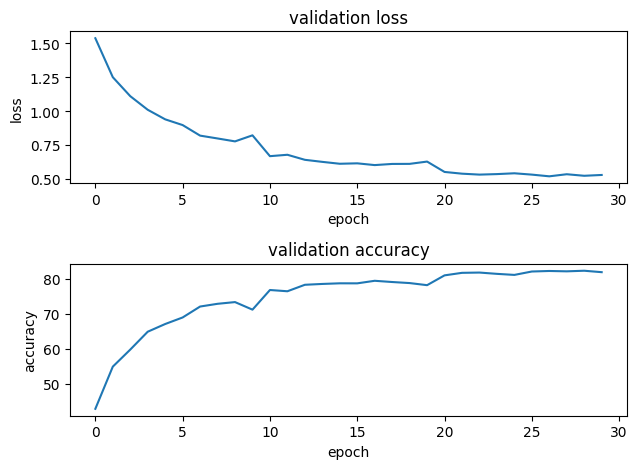

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)
ax[0].plot(val_loss_log)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('validation loss')


ax[1].plot(val_acc_log)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('validation accuracy')
plt.tight_layout()

In [8]:
# Optional Task: HoG Features + Linear Classifier
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import cv2

def extract_hog_features(images):
    """
    Extract HoG features from images
    Parameters: pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9
    """
    hog_features = []
    for img in images:
        # Convert from tensor to numpy and denormalize
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
        img_np = (img_np * 255).astype(np.uint8)
        
        # Convert to grayscale for HoG
        if len(img_np.shape) == 3:
            img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_np
        
        # Extract HoG features
        features = hog(img_gray, 
                      orientations=9, 
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      feature_vector=True)
        hog_features.append(features)
    
    return np.array(hog_features)

# Extract HoG features from training set (sample for speed)
print("Extracting HoG features from training set (this may take a while)...")
train_hog_features = []
train_hog_labels = []

# Sample a subset for faster computation
sample_size = 5000
sample_indices = np.random.choice(len(trainset), sample_size, replace=False)

for idx in sample_indices[:1000]:  # Process first 1000 for demonstration
    img, label = trainset[idx]
    features = extract_hog_features([img])[0]
    train_hog_features.append(features)
    train_hog_labels.append(label)

train_hog_features = np.array(train_hog_features)
train_hog_labels = np.array(train_hog_labels)

# Extract HoG features from validation set (sample)
print("Extracting HoG features from validation set...")
val_hog_features = []
val_hog_labels = []

for idx in range(min(500, len(valset))):
    img, label = valset[idx]
    features = extract_hog_features([img])[0]
    val_hog_features.append(features)
    val_hog_labels.append(label)

val_hog_features = np.array(val_hog_features)
val_hog_labels = np.array(val_hog_labels)

# Standardize features
scaler = StandardScaler()
train_hog_features_scaled = scaler.fit_transform(train_hog_features)
val_hog_features_scaled = scaler.transform(val_hog_features)

# Train linear classifier
print("Training linear classifier on HoG features...")
hog_classifier = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
hog_classifier.fit(train_hog_features_scaled, train_hog_labels)

# Evaluate
train_pred = hog_classifier.predict(train_hog_features_scaled)
val_pred = hog_classifier.predict(val_hog_features_scaled)

train_acc = accuracy_score(train_hog_labels, train_pred)
val_acc = accuracy_score(val_hog_labels, val_pred)

print(f"\nHoG + Linear Classifier Results:")
print(f"Training Accuracy: {100*train_acc:.2f}%")
print(f"Validation Accuracy: {100*val_acc:.2f}%")
print(f"\nNote: This is a demonstration with a subset of data. Full implementation would process all samples.")

Extracting HoG features from training set (this may take a while)...
Extracting HoG features from validation set...
Training linear classifier on HoG features...

HoG + Linear Classifier Results:
Training Accuracy: 97.20%
Validation Accuracy: 33.20%

Note: This is a demonstration with a subset of data. Full implementation would process all samples.


c:\Users\Qifan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


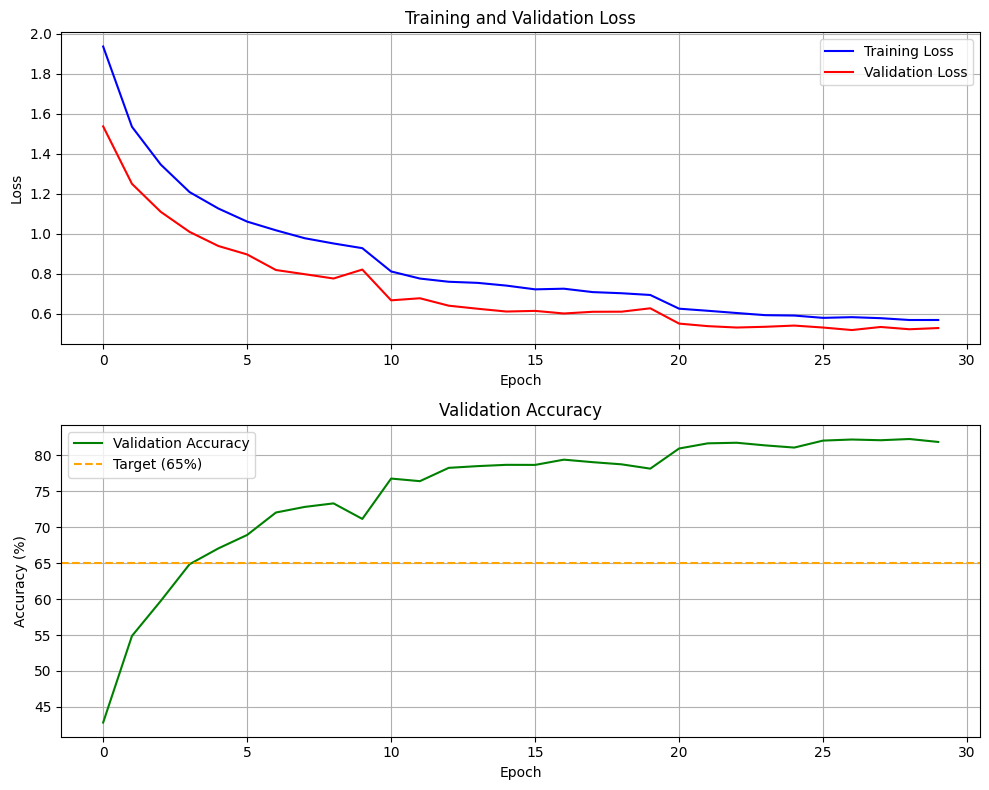

Best validation accuracy: 82.25%
Final validation accuracy: 81.84%


In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot losses
ax[0].plot(train_loss_log, label='Training Loss', color='blue')
ax[0].plot(val_loss_log, label='Validation Loss', color='red')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[0].grid(True)

# Plot accuracy
ax[1].plot(val_acc_log, label='Validation Accuracy', color='green')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Validation Accuracy')
ax[1].legend()
ax[1].grid(True)
ax[1].axhline(y=65, color='orange', linestyle='--', label='Target (65%)')
ax[1].legend()

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(val_acc_log):.2f}%")
print(f"Final validation accuracy: {val_acc_log[-1]:.2f}%")

Testing

The other things to do is to calculate the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to see the accuracy of individual classes.

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


Evaluating on test set...

Overall Test Accuracy: 81.78%

Per-Class Test Accuracy:
------------------------------------------------------------
plane     :  83.70% (837/1000)
car       :  91.00% (910/1000)
bird      :  71.70% (717/1000)
cat       :  65.70% (657/1000)
deer      :  76.20% (762/1000)
dog       :  81.40% (814/1000)
frog      :  79.90% (799/1000)
horse     :  86.90% (869/1000)
ship      :  90.30% (903/1000)
truck     :  91.00% (910/1000)
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

       plane     0.8480    0.8370    0.8425      1000
         car     0.9343    0.9100    0.9220      1000
        bird     0.7888    0.7170    0.7512      1000
         cat     0.6311    0.6570    0.6438      1000
        deer     0.8420    0.7620    0.8000      1000
         dog     0.6672    0.8140    0.7333      1000
        frog     0.9080    0.7990    0.8500      1000
       horse     0.

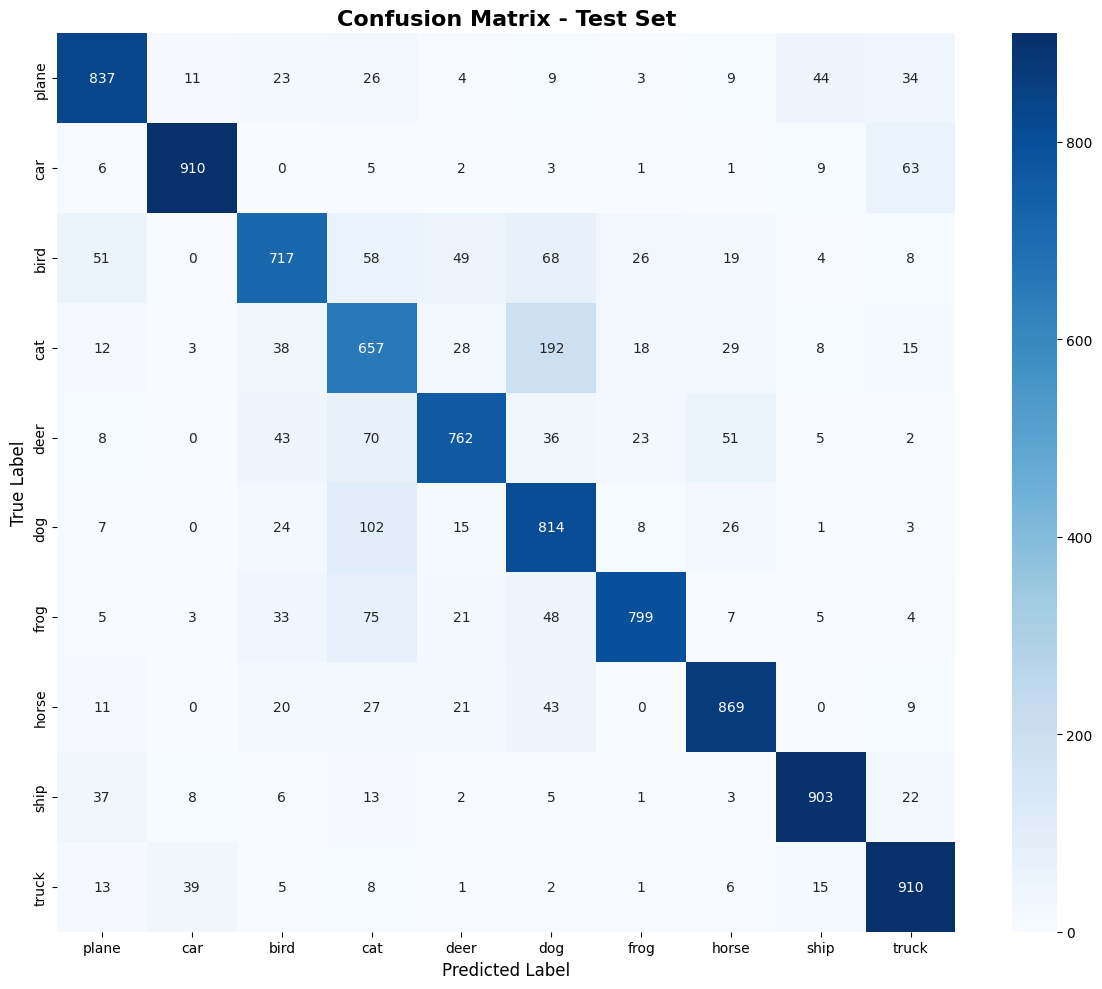

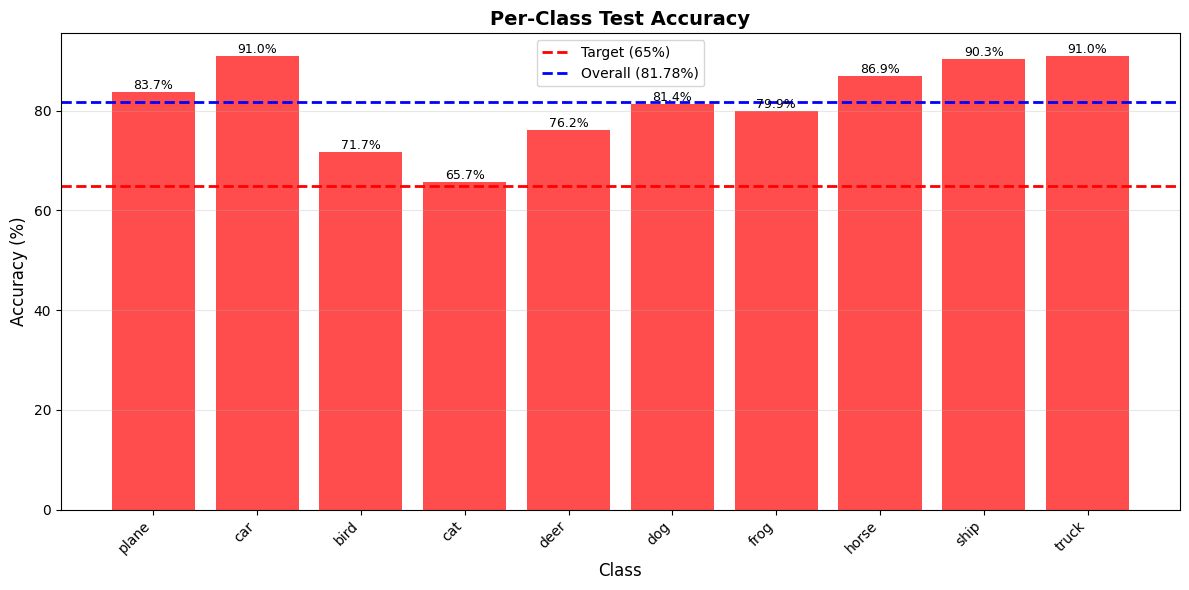


Summary Statistics:
Classes above 65% accuracy: 10/10
Classes above 50% accuracy: 10/10
Best performing class: car (91.00%)
Worst performing class: cat (65.70%)
Average per-class accuracy: 81.78%


In [11]:

# Task 3: Calculate per-class accuracy and confusion matrix
model.eval()
all_preds = []
all_labels = []
total_correct_pred = 0

print("Evaluating on test set...")
for i, batch in enumerate(testloader):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        curr_correct_pred = (predicted == labels).sum().item()
        total_correct_pred += curr_correct_pred

# Total accuracy
acc = total_correct_pred / len(testloader.dataset)
print(f"\n{'='*60}")
print(f"Overall Test Accuracy: {100*acc:.2f}%")
print(f"{'='*60}\n")

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate per-class accuracy
class_correct = np.diag(cm)
class_total = cm.sum(axis=1)
class_acc = class_correct / class_total

# Print per-class accuracy
print("Per-Class Test Accuracy:")
print("-" * 60)
for i, class_name in enumerate(classes):
    print(f"{class_name:10s}: {100*class_acc[i]:6.2f}% ({class_correct[i]}/{class_total[i]})")
print("-" * 60)

# Print classification report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Bar plot of per-class accuracy
plt.figure(figsize=(12, 6))
colors = ['green' if acc >= 65 else 'orange' if acc >= 50 else 'red' for acc in class_acc]
bars = plt.bar(range(len(classes)), 100*class_acc, color=colors, alpha=0.7)
plt.axhline(y=65, color='red', linestyle='--', linewidth=2, label='Target (65%)')
plt.axhline(y=100*acc, color='blue', linestyle='--', linewidth=2, label=f'Overall ({100*acc:.2f}%)')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Test Accuracy', fontsize=14, fontweight='bold')
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc_val) in enumerate(zip(bars, class_acc)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{100*acc_val:.1f}%',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'='*60}")
print("Summary Statistics:")
print(f"{'='*60}")
print(f"Classes above 65% accuracy: {sum(class_acc >= 0.65)}/{len(classes)}")
print(f"Classes above 50% accuracy: {sum(class_acc >= 0.50)}/{len(classes)}")
print(f"Best performing class: {classes[np.argmax(class_acc)]} ({100*max(class_acc):.2f}%)")
print(f"Worst performing class: {classes[np.argmin(class_acc)]} ({100*min(class_acc):.2f}%)")
print(f"Average per-class accuracy: {100*np.mean(class_acc):.2f}%")
print(f"{'='*60}")